# Часть 2. Variational Autoencoder (VAE) .

Оригинальная статья http://arxiv.org/abs/1312.6114

В этой части мы обучим автоенкодер и вариационный автоенкодер на датасете "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/).

### Подготовьте данные

In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2020-07-01 17:11:28--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2,7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2,67K  --.-KB/s    in 0s      

2020-07-01 17:11:29 (25,5 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [3]:
#@title Utility functions
import numpy as np
import os
import skimage.io
import skimage
import skimage.transform
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ): # sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(lambda img: skimage.io.imread(img))\
                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: skimage.img_as_ubyte(skimage.transform.resize(img,[dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [909]:
data_m, attrs = fetch_lfw_dataset(dimx=32,dimy=32)

In [555]:
data = data/255
#np.savez("real.npz", Pictures=data.reshape(data.shape[0], 32*32*3))

In [556]:
X_train = data[:10000] #.reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:] #.reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 32, 32, 3)
(3143, 32, 32, 3)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [7]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [168]:
# def plot_gallery(images, h, w, n_row=3, n_col=6):
#     """Helper function to plot a gallery of portraits"""
#     plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
#     plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
#         plt.xticks(())
#         plt.yticks(())

In [105]:
def plot_gallery(images, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

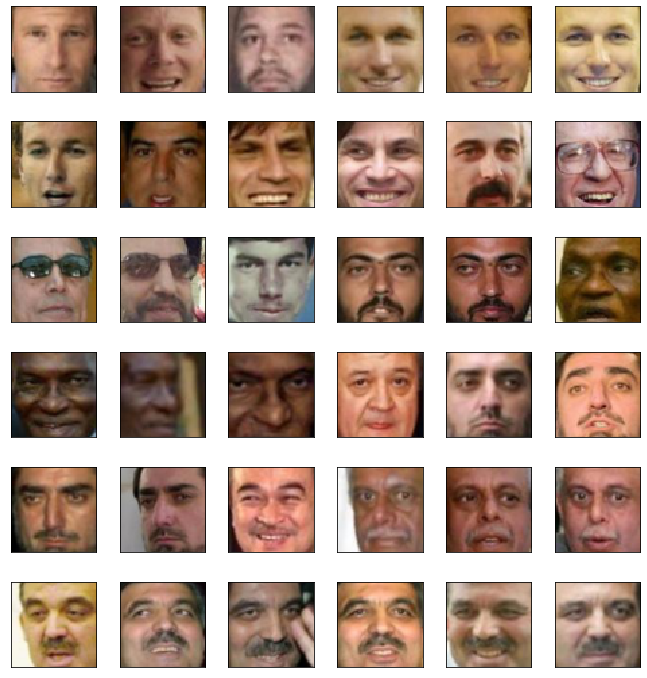

In [8]:
plot_gallery(X_train, 6, 6)

In [15]:
train = data_utils.TensorDataset(torch.Tensor(X_train).transpose(1,3), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val).transpose(1,3), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

In [8]:
batch = next(iter(train_loader))
batch[0].shape

torch.Size([100, 3, 32, 32])

## Autoencoder

В чем суть вариационного автоенкодера со всеми сложными формулами и регуляризациями? Чтобы ощутить разницу обучите сначала автоенкодер:

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" alt="Autoencoder">

In [262]:
import math 

class Encoder(nn.Module):
    def __init__(self, dims, n):
        super(Encoder, self).__init__()
        self.dims = dims
        self.fc = nn.Sequential(nn.Linear(dims, dims), nn.ReLU())
        
        params = {
        "padding": 1,
        "kernel_size": 3,
        "stride": 1,
        "dilation": 1,
        "padding_mode": "zero",
        "bias":False,
    }
        
        layers = [nn.Conv2d(3, dims, **params)]
        for i in range(n):
            layers.append(nn.Conv2d(dims, dims, **params))
            layers.append(CLayerNorm(dims))
            layers.append(nn.ReLU())
          
        layers+=[nn.Conv2d(dims, dims, **params), nn.AdaptiveMaxPool2d(1)]
        self.layers = nn.Sequential(*layers)
            
    def forward(self, x):
        B = x.shape[0]
        x = self.layers(x) # BxCxHxW - > BxCx1x1
        x = x.view(B, self.dims) # BxDims
        return self.fc(x)
    
    
class Decoder(nn.Module):
    """
    (∗,C×r^2,H,W) to a tensor of shape (∗,C,H×r,W×r)
    """
    def __init__(self, dims, HxW):
        super(Decoder, self).__init__()
        self.dims = dims
        # (Hin+2×padding−dilation×(kernel_size−1)−1)/stride + 1
                                      
        params = {
            "padding": 1,
            "kernel_size": 3,
            "stride": 1,
            "dilation": 1,
            "padding_mode": "zero",
            "bias":False,
        }

        is_power, n_output = self.pow_of_two(HxW)
        assert is_power, "Output size is not power of two"
        is_power, n_dims = self.pow_of_two(dims)
        assert is_power, "Dim size is not power of two"
        assert n_output <= n_dims, "Output size power is greater than dim size power"
        
        layers = []
        for i in range(n_output):            
            layers.append(nn.Conv2d(dims, dims*2, **params))   # 126 : 256  : 1 x 1
            layers.append(CLayerNorm(dims*2))
            layers.append(nn.ReLU())
            layers.append(nn.PixelShuffle(2))                  # 64 :       : 2 x 2
            layers.append(nn.Conv2d(dims//2, dims, **params))     # 64 : 64    : 2 x 2
            layers.append(nn.ReLU())
            
#             layers.append(nn.Conv2d(dims, dims, **params)) 
#             layers.append(nn.ReLU())
            
        layers.append(nn.Conv2d(dims, 3, **params)) 
        layers.append(nn.ReLU())    
        self.layers = nn.Sequential(*layers)
        
    def pow_of_two(self, x):
        n = math.log(x,2)
        if x == 2**int(n):
            return True, int(n)
        return False, n

    def forward(self, x):
        B = x.shape[0]
        x = x.view(B,self.dims,1,1) # BxDimsx1x1
        x = self.layers(x) # BxCx1x1 - > Bx1xHxW 
        return x


In [264]:
dimZ = 128 # Учитывая, что задача реконструкции лица, какой размер скрытого представления кажется разумным?

# Определите декодер и енкодер как сети с 1-м скрытым полносвязным слоем
# (это будет означать что в каждой сети будет 2 полносвзяных слоя)
# Используйте ReLU на активациях скрытых слоёв
# GlorotUniform инициализация для W
# Zero инициализация для biases
# Удобно добавить sigmoid активацию на выход сети, чтобы получить нормализованный output

class Autoencoder(nn.Module):
    def __init__(self, dims, HxW):
        super(Autoencoder, self).__init__()
        
        #TODO
        _, n = self.pow_of_two(HxW)
        self.encoder = Encoder(dims, int(n))
        self.decoder = Decoder(dims, HxW)
          
    def pow_of_two(self, x):
        n = math.log(x,2)
        if x == 2**int(n):
            return True, int(n)
        return False, n 
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        # compute mse between all elements and average for batch sum(1).mean()
        mse_loss  = torch.pow(x - reconstruction, 2).view(x.shape[0], -1).sum(1).mean()
        return {'rec_img':reconstruction, 'code':latent_code, 'loss':mse_loss}

In [265]:
# Создаём MSE loss function
#criterion = torch.nn.MSELoss()

dimZ = 128
autoencoder = Autoencoder(dimZ, 32).cuda()
# используем Adam оптимизиатор
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

In [266]:
def plot_intermediate(model, dataset):
    model.eval()
    pass

def train(model, train_loader, epochs, optimizer):
    model.train()
    
    for i in range(epochs):
        losses = []
        for k, batch in enumerate(train_loader):
            optimizer.zero_grad()
            batch = batch[0].cuda()
            out = model(batch)
            out['loss'].backward()
            optimizer.step()
            
            losses.append(out['loss'].item())
        if i%5 == 0:
            print(f'epoch {i+1} loss: {sum(losses)/len(losses)}')

In [267]:
train(autoencoder, train_loader, 135, optimizer)

epoch 1 loss: 143.32157409667968
epoch 6 loss: 40.32817710876465
epoch 11 loss: 30.66404077529907
epoch 16 loss: 27.52961015701294
epoch 21 loss: 24.436267108917235
epoch 26 loss: 22.36994348526001
epoch 31 loss: 20.248648509979247
epoch 36 loss: 19.187485790252687
epoch 41 loss: 18.118318147659302
epoch 46 loss: 17.037389450073242
epoch 51 loss: 15.96511016845703
epoch 56 loss: 15.444184732437133
epoch 61 loss: 15.17773443222046
epoch 66 loss: 14.957630882263183
epoch 71 loss: 13.436058969497681
epoch 76 loss: 13.654807682037353
epoch 81 loss: 13.188312673568726
epoch 86 loss: 13.00829598426819
epoch 91 loss: 12.69297914505005
epoch 96 loss: 11.52750057220459
epoch 101 loss: 11.222162351608276
epoch 106 loss: 10.973450851440429
epoch 111 loss: 10.399874286651611
epoch 116 loss: 10.70558567047119
epoch 121 loss: 9.92397089958191
epoch 126 loss: 9.716486368179321
epoch 131 loss: 10.231077852249145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


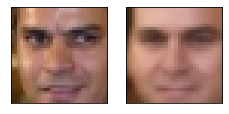

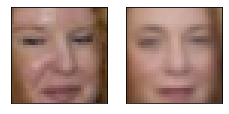

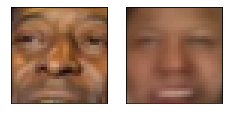

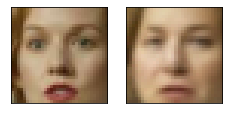

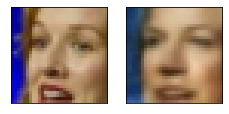

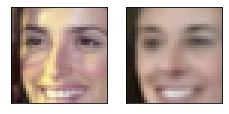

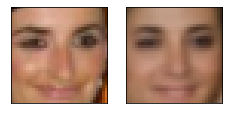

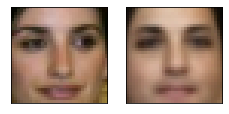

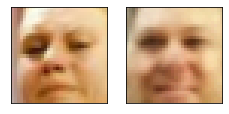

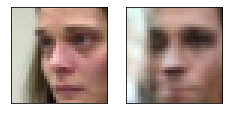

In [269]:
# Отобразите реконструкции
for j, data in enumerate(val_loader, 0):
    inp = data[0].cuda()
    res = autoencoder(inp)
    rec_img = res['rec_img']
    plot_gallery([data[0].transpose(1, 3).numpy()[0], rec_img.transpose(1, 3).data.cpu().numpy()[0]], n_row=1, n_col=2)
    if (j >= 9):
        break

Реконструкция не так уж и плоха, да?

## Sampling

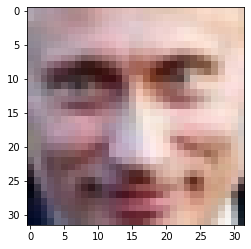

In [35]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.transpose(1, 3).numpy()[0])

In [37]:
# plt.figure(figsize=(10, 12))
# plt.suptitle('Twin farm')
# for i in range(len(image_progress[:20])):
#     plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
#     plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
#     plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
#     plt.title('Epoch = {}'.format(i * 5 + 1))
#     plt.axis('off')
# plt.tight_layout()

Давайте насемплим несколько случайных латентных векторов $z$ и сделаем inference - реконструируем изображения из $z$

In [44]:
output.data.transpose(1, 3).cpu().numpy().shape

(25, 32, 32, 3)

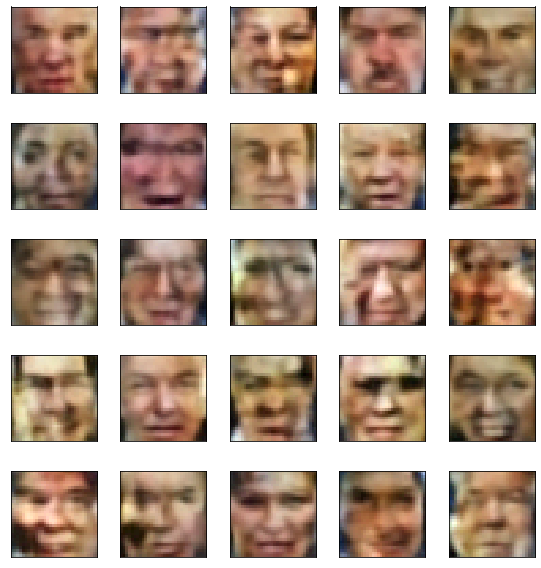

In [272]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(torch.from_numpy(z).cuda()).clamp(0, 1)
plot_gallery(output.data.transpose(1, 3).cpu().numpy(), n_row=5, n_col=5)

Если мы будем семплить $z$ из нормального распределения, мы в итоге получим на выходе все возможные лица? Как вы считаете?

## Variational Autoencoder

Байесовский подход в глубоком обучении рассматривает всё в терминах распределений. Теперь наш енкодер будет генерировать не просто $z$, но и апостериорное распределение $q(z|x)$. В нашем случае распределение $q$ является гауссовским распределением $N(\mu, \sigma)$ с параметрами $\mu$, $\sigma$. Технически, первое отличие заключается в том, что вам нужно разделить bottleneck слой на два слоя. Один полносвязный слой будет генерировать вектор $\mu$, а другой - вектор $\sigma$. Reparametrization trick должен быть реализован с помощью **gaussian_sampler** слоя, который генерирует случайный вектор $\epsilon$ и возвращает $z=\mu+\sigma\epsilon \sim N(\mu, \sigma)$.

Поскольку наш декодер также является функцией, которая генерирует распределение, нам необходимо выполнить такое же разбиение для выходного слоя. При тестировании модели мы будем смотреть только на средние значения, поэтому одной частью выходных данных будет фактический выходной сигнал автоэнкодера.

Реализуйте простейшую версию VAE - один $z$ на вход. Можно также попробовать рассмотреть выборку из нескольких $z$  на один вход и далее усреднить их.

In [896]:
import math

params_one = {
    "padding": 1,
    "kernel_size": 3,
    "stride": 1,
    "dilation": 1,
    "padding_mode": "relpicate",
    "bias":True,
}

params_two = {
    "padding": 3,
    "kernel_size": 7,
    "stride": 1,
    "dilation": 1,
    "padding_mode": "relpicate",
    "bias":True,
}
        
def pow_of_two(x):
    n = math.log(x,2)
    if x == 2**int(n):
        return True, int(n)
    return False, n
   
class EncoderV(nn.Module):
    def __init__(self, dims, n):
        super(EncoderV, self).__init__()
        self.dims = dims
        self.fc = nn.Sequential(nn.Linear(dims*2, dims*2, bias=True), 
                                nn.ReLU())
        
        layers = [nn.Conv2d(3, dims//n, **params_two)]
        for i in range(n-1):
            layers+=[nn.Conv2d(dims//(n-i), dims//(n-i-1), **params_one), 
                     nn.ReLU(),
                     nn.AvgPool2d((2, 2))]
            
        layers+=[nn.Conv2d(dims//(n-i-1), dims*2, **params_one), 
                 nn.AvgPool2d((2, 2)),
                 nn.ReLU()]
        
        self.layers = nn.Sequential(*layers)
            
    def forward(self, x):
        B = x.shape[0]
        x = self.layers(x)         # BxCxHxW -> BxCx1x1
        x = x.view(B, self.dims*2)   # BxDims
        x = self.fc(x)
        mu, log_sigma = x.chunk(2, dim=1)
        return mu, log_sigma
    
class DecoderV(nn.Module):
    """
    (∗,C×r^2,H,W) to a tensor of shape (∗,C,H×r,W×r)
    """
    def __init__(self, dims, HxW):
        super(DecoderV, self).__init__()
        self.dims = dims
        # (Hin+2×padding−dilation×(kernel_size−1)−1)/stride + 1
                                      
        is_power, n_output = pow_of_two(HxW)
        assert is_power, "Output size is not power of two"
        is_power, n_dims = pow_of_two(dims)
        assert is_power, "Dim size is not power of two"
        assert n_output <= n_dims, "Output size power is greater than dim size power"
        
        layers = []
        for i in range(n_output):            
            layers+=[nn.Conv2d(dims, dims*2, **params_one),
                     nn.ReLU(),
                     nn.PixelShuffle(2)]        
            dims = dims // 2                       
            
        layers+=[nn.Conv2d(dims, dims, **params_one), nn.ReLU()]
        layers.append(nn.Conv2d(dims, 3, **params_one)) 
        layers.append(nn.ReLU())    
        self.layers = nn.Sequential(*layers)
   
    def forward(self, z):
        B = z.shape[0]
        z = z.view(B,self.dims,1,1) # BxDimsx1x1
        z = self.layers(z) # BxCx1x1 - > Bx3xHxW 
        return z

In [900]:
# чтобы сравниться с autoencoder выберите такой же dimZ как и до этого
dimZ = 128

# напишите сеть
# можно посмотреть на код семинара, либо https://github.com/pytorch/examples/blob/master/vae/main.py

def softclip(tensor, min):
    """ Clips the tensor values at the minimum value min in a softway. Taken from Handful of Trials """
    result_tensor = min + F.softplus(tensor - min)

    return result_tensor

class VAE(nn.Module):
    def __init__(self, HxW, dims):
        super(VAE, self).__init__()
        
        _, n = pow_of_two(HxW)
        self.encoder = EncoderV(dims, int(n))
        self.decoder = DecoderV(dims, HxW)
        self.log_sigma = torch.nn.Parameter(torch.full((1,), 0)[0], requires_grad=True)    
        
        #self.encoder = ConvEncoder((3,32,32),dims)
        #self.decoder =  ConvDecoder((3,32,32),dims)
   
    def gaussian_nll(self, mu, log_sigma, x):
        return 0.5 * torch.pow((x - mu) / log_sigma.exp(), 2) + log_sigma + 0.5 * np.log(2 * np.pi)
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        # gaussian_sampler
        z = torch.randn_like(mu) * torch.exp(0.5 * log_var) + mu 
        x_z = self.decoder(z)
        log_sigma = softclip(self.log_sigma, -6)
        recon_loss = self.gaussian_nll(x, log_sigma, x_z).sum() 
        
        kl_loss = (-0.5 *(1 + log_var - mu.pow(2) - log_var.exp())).sum()
        #kl_loss = (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())) #.sum(1).mean()
        #print(kl_loss.shape())
            
#         kl_loss = -log_sigma - 0.5 + (torch.exp(2 * log_sigma) + mu.pow(2)) * 0.5
#         kl_loss = kl_loss.sum(1).mean()

        return {'rec_img':x_z,
               'kl':kl_loss,
               'recon_loss':recon_loss,
               'total_loss':kl_loss+recon_loss}

Функционал, который будем оптимизировать для VAE имеет собственное название - variational lowerbound. Мы будем его максимизировать. Вот он (один $z$ на вход $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Реализуйте две функции, одна из которых будет считать KL-дивергенцию, а другая log-likelihood вашего output. Вот необходимая математика для удобства:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Не забывайте, что вы используете $\log\sigma$ на вход. Почему не просто $\sigma$?

Теперь учим модель:

In [974]:
vae = VAE(32,dimZ).cuda()
# используем Adam оптимизиатор
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

def train(model, train_loader, epochs, optimizer):
    model.train()  
    
    for i in range(epochs):
        kl_losses = []
        rec_losses = []
        for k, batch in enumerate(train_loader):
            optimizer.zero_grad()
            batch = batch[0].cuda()
            out = model(batch)
            (out['kl']+out['recon_loss']).backward()
        
            optimizer.step()
            kl_losses.append(out['kl'].item())
            rec_losses.append(out['recon_loss'].item())
        if i%10 == 0:
            print(f'epoch {i+1} kl_loss: {sum(kl_losses)/len(kl_losses)}')
            print(f'epoch {i+1} recon_loss: {sum(rec_losses)/len(rec_losses)}')

In [975]:
train(vae, train_loader, 400, optimizer)

epoch 1 kl_loss: 17459.236259765625
epoch 1 recon_loss: -354936.428125
epoch 11 kl_loss: 21142.10529296875
epoch 11 recon_loss: -363053.5953125
epoch 21 kl_loss: 21686.61189453125
epoch 21 recon_loss: -363821.811875
epoch 31 kl_loss: 21915.58853515625
epoch 31 recon_loss: -364097.6221875
epoch 41 kl_loss: 22125.11404296875
epoch 41 recon_loss: -364736.4415625
epoch 51 kl_loss: 22101.46173828125
epoch 51 recon_loss: -364811.8425
epoch 61 kl_loss: 22226.12859375
epoch 61 recon_loss: -365226.8046875
epoch 71 kl_loss: 22340.40287109375
epoch 71 recon_loss: -365177.138125
epoch 81 kl_loss: 22370.495859375
epoch 81 recon_loss: -365646.39875
epoch 91 kl_loss: 22444.648046875
epoch 91 recon_loss: -365861.2165625
epoch 101 kl_loss: 22433.63208984375
epoch 101 recon_loss: -366047.5734375
epoch 111 kl_loss: 22510.67998046875
epoch 111 recon_loss: -366456.95
epoch 121 kl_loss: 22599.34052734375
epoch 121 recon_loss: -366668.794375
epoch 131 kl_loss: 22699.8233984375
epoch 131 recon_loss: -366635.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


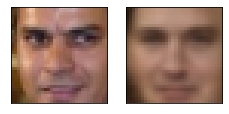

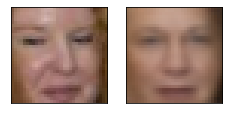

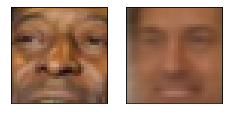

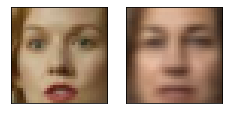

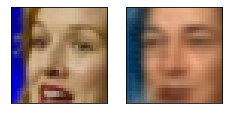

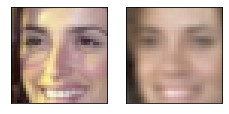

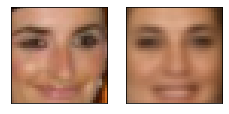

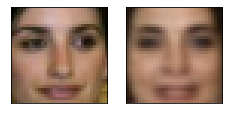

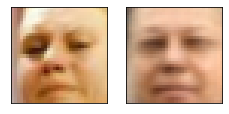

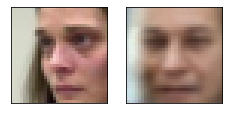

In [988]:
# Отобразите реконструкции
for j, data in enumerate(val_loader, 0):
    inp = data[0].cuda()
    res = vae(inp)
    rec_img = res['rec_img']
    plot_gallery([data[0].transpose(1, 3).numpy()[0], rec_img.transpose(1, 3).data.cpu().numpy()[0]], n_row=1, n_col=2)
    if (j >= 9):
        break

И теперь насемплим с помощью VAE:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


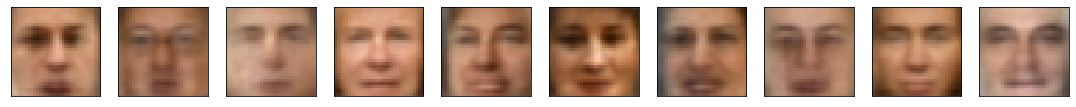

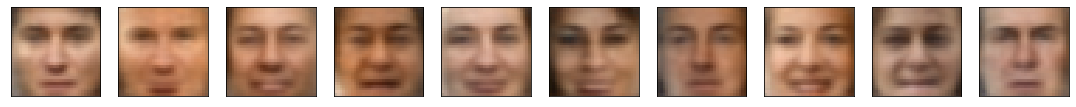

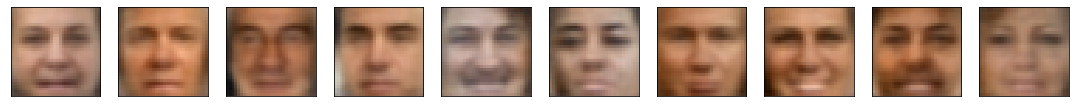

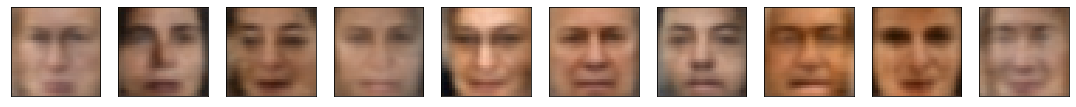

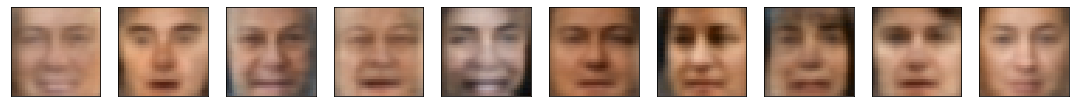

In [1023]:
cols = 10
rows = 5
for _ in range(rows):
    images = []
    for i in range(cols):
        latent = torch.normal(mean=2,std=3, size=(1,128)).cuda() # большая ошиюка KL поэтому можно подбирать разные параметры
        img = vae.decoder(latent)
        images.append(img.transpose(1, 3).detach().cpu().numpy()[0])
    plot_gallery(images, n_row=1, n_col=cols)

Даже если на практике вы не видите большой разницы между AE и VAE, или VAE еще хуже, маленький "Байес" внутри вас должен прыгать от радости прямо сейчас.

В VAE вы можете по-настоящему семплить из распределения изображений $p(x)$, тогда как в AE нет простого и правильного способа сделать это.

## И напоследок!

Если вам удалось обучить свои автоэнкодеры и они что-то узнали о мире, то пришло время воспользоваться этим. Как вы могли заметить, в наборе данных есть атрибуты лица. Нас интересует параметр-колонка "Smiling", но можете поробовать и другие! Вот первая задача:

1) Извлеките атрибут "Smilling" и создайте два набора изображений: 10 улыбающихся и 10 не улыбающихся.

2) Вычислите скрытые (латентные) представления для каждого изображения в «улыбающемся» наборе и усредните эти вектора. Сделайте то же самое для "не улыбающегося" набора. Вы тем самым нашли **"векторное представление"** атрибутов "smile" и "no smile".

3) Вычислите разницу: вектор «улыбка» минус вектор «не улыбка».

3) Теперь проверьте, работает ли **«арифметика признаков (фичей)»**. Возьмите лицо без улыбки, закодируйте его с помощью екнодера, добавьте к нему разницу из пункта 3) и подавйте на вход декодеру. Проверьте работает ли в случае AE? в случае VAE?

In [ ]:
def plot_gallery(images, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [566]:
smiling = attrs[attrs['Smiling']>1.5].index.to_list()
non_smiling = attrs[attrs['Smiling']<-1].index.to_list()
#smile_imgs = [data[x] for x in smiling]

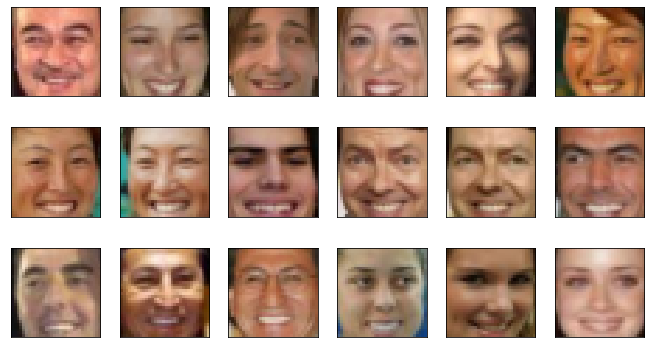

In [600]:
plot_gallery(data[smiling])

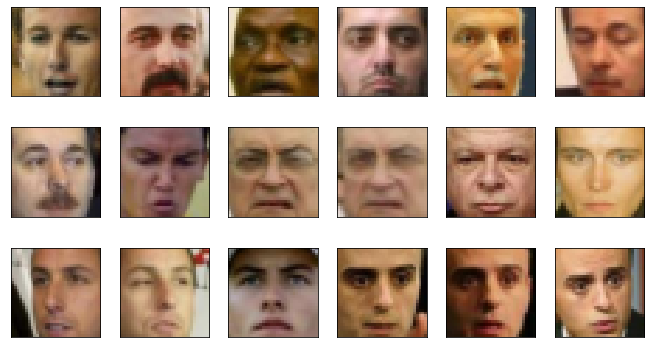

In [567]:
plot_gallery(data_m[non_smiling])

### CHECK IF ENCODER GOT SMILES

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


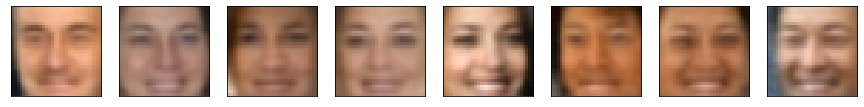

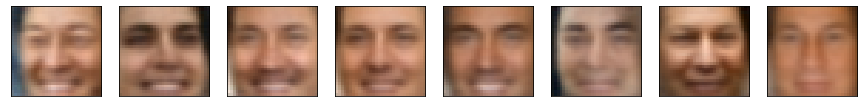

In [997]:
def plot_some(data):
    cols = 8
    rows = 2
    k = 0 
    for _ in range(rows):
        images = []
        for i in  range(cols):
            img = data[k+i]
            inp = torch.tensor(img/255).unsqueeze(0).transpose(1,3).type(torch.float32).cuda()
            img = vae(inp)['rec_img']
            images.append(img.transpose(1, 3).detach().cpu().numpy()[0])
        k = i 
        plot_gallery(images, n_row=1, n_col=cols)
        
plot_some(data_m[smiling])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


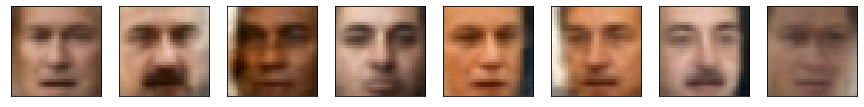

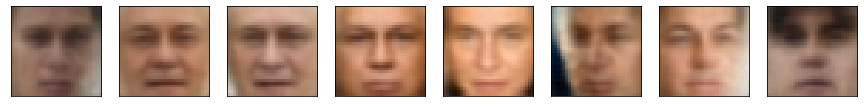

In [998]:
plot_some(data_m[non_smiling])

### много не нужных приседаний из np в tensor : (((

In [1003]:
def get_mean_code(data):
    codes = np.zeros(shape=(190,128))
    for  i in range(190):
        inp = torch.tensor(data[i]/255).unsqueeze(0).transpose(1,3).type(torch.float32).cuda()
        mu, sigma = vae.encoder(inp)
        codes[i] = (mu+sigma).detach().cpu().numpy()
    return codes.mean(0)

code_smile = get_mean_code(data_m[smiling])
code_non = get_mean_code(data_m[non_smiling])

### ВЕКТОР УЛЫБКИ ПОХОЖ НА ЖЕНЩИНУ

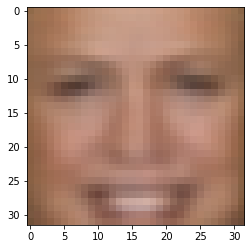

In [1004]:
plt.imshow(vae.decoder(torch.tensor(code_smile - code_non).unsqueeze(0).type(torch.float32).cuda()).transpose(1,3).detach().cpu().numpy()[0])

In [1005]:
faces = attrs[(attrs.Male > 1) & (attrs.White < -1) & (attrs.Mustache > 2)].index.to_list()
faces

[3598, 5133, 8620, 10284, 11153, 13139]

In [1006]:
initial_codes = []
for idx in faces[3:6]:
    img = torch.tensor(data_m[idx]/255).unsqueeze(0).transpose(1,3).type(torch.float32).cuda()
    mu, sigma = vae.encoder(img)
    initial_codes.append((mu+sigma))

smile_code = torch.tensor(code_smile - code_non).unsqueeze(0).cuda()


koefs = np.linspace(0,1, 10)

f1 = []
f2 = []
f3 = []
for i in range(10):
    code_one =  initial_codes[0]*(1-koefs[i]) + smile_code*koefs[i]
    f1.append(vae.decoder(code_one.unsqueeze(0).type(torch.float32).cuda()).transpose(1,3).detach().cpu().numpy()[0])
    
    code_two =  initial_codes[1]*(1-koefs[i]) + smile_code*koefs[i]
    f2.append(vae.decoder(code_two.unsqueeze(0).type(torch.float32).cuda()).transpose(1,3).detach().cpu().numpy()[0])
    
    code_three =  initial_codes[2]*(1-koefs[i]) + smile_code*koefs[i]
    f3.append(vae.decoder(code_three.unsqueeze(0).type(torch.float32).cuda()).transpose(1,3).detach().cpu().numpy()[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


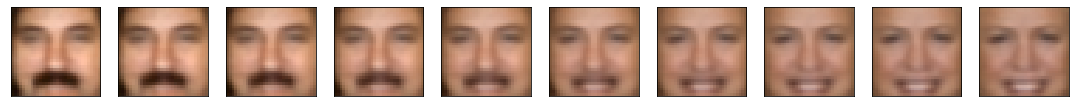

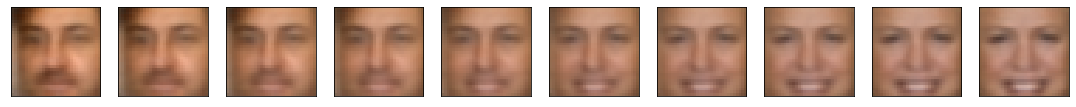

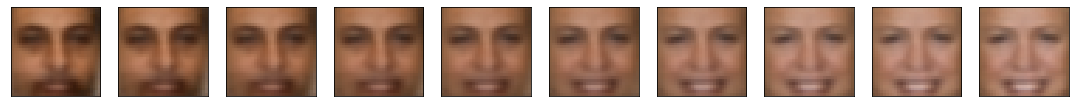

In [1007]:
plot_gallery(f1, n_row=1, n_col=10)
plot_gallery(f2, n_row=1, n_col=10)
plot_gallery(f3, n_row=1, n_col=10)